### Import libraries

In [1]:
import pandas as pd
import numpy as np
 
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

### Download dataset

In [2]:
# data = 'https://raw.githubusercontent.com/gastonstat/CreditScoring/master/CreditScoring.csv'
# !wget $data

In [3]:
df = pd.read_csv('CreditScoring.csv', sep=',')

df.head()

,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


In [4]:
df.columns = df.columns.str.lower()

In [5]:
status_values = {
    1:"ok", 
    2:"default",
    0:"unk"
}

df.status = df.status.map(status_values)

In [6]:
home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}
df.home = df.home.map(home_values)
 
marital_values = {
    1: 'single', 
    2: 'married', 
    3: 'widow', 
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}
df.marital = df.marital.map(marital_values)
 
records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}
df.records = df.records.map(records_values)
 
job_values = {
    1: 'fixed', 
    2: 'partime', 
    3: 'freelance', 
    4: 'others',
    0: 'unk'
}
df.job = df.job.map(job_values)

In [7]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,763317.0,1060341.0,404382.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,8703625.0,10217569.0,6344253.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3500.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,166.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,99999999.0,99999999.0,99999999.0,5000.0,11140.0


In [8]:
for c in ['income', 'assets', 'debt']:
    df[c]= df[c].replace(to_replace=99999999.0,value=np.nan)

In [9]:
df = df[df['status']!='unk'].reset_index()

In [10]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=11)

df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=11) # 0.25 x 0.8 = 0.2

In [11]:
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

In [12]:
y_train = (df_train.status=='default').astype(int).values
y_val = (df_val.status=='default').astype(int).values
y_test = (df_test.status=='default').astype(int).values

In [13]:
del df_train['status']
del df_val['status']
del df_test['status']

In [14]:
def assess_risk(client):
    if client['records'] == 'yes':
        if client['job'] == 'parttime':
            return 'default'
        else:
            return 'ok'
    else:
        if client['assets']>6000:
            return 'ok'
        else:
            return 'default'

In [15]:
xi = df_train.iloc[1].to_dict()

In [16]:
assess_risk(xi)

'ok'

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score

In [18]:
train_dicts = df_train.fillna(0).to_dict(orient='records')    

In [19]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

In [20]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [21]:
val_dicts = df_val.fillna(0).to_dict(orient='records')
X_val = dv.transform(val_dicts)
y_pred = dt.predict_proba(X_val)[:,1]
roc_auc_score(y_val, y_pred)

0.6488278317308858

In [22]:
y_pred =dt.predict_proba(X_train)[:,1]
roc_auc_score(y_train, y_pred)

1.0

In [23]:
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [24]:
y_pred =dt.predict_proba(X_train)[:,1]
auc = roc_auc_score(y_train, y_pred)
print('train',auc)

y_pred =dt.predict_proba(X_val)[:,1]
auc = roc_auc_score(y_val, y_pred)
print('val',auc)

train 0.7761016984958594
val 0.7389079944782155


In [25]:
from sklearn.tree import export_text

In [26]:
print(export_text(dt, feature_names=dv.get_feature_names_out()))

|--- records=yes <= 0.50
|   |--- job=partime <= 0.50
|   |   |--- income <= 74.50
|   |   |   |--- class: 0
|   |   |--- income >  74.50
|   |   |   |--- class: 0
|   |--- job=partime >  0.50
|   |   |--- assets <= 8750.00
|   |   |   |--- class: 1
|   |   |--- assets >  8750.00
|   |   |   |--- class: 0
|--- records=yes >  0.50
|   |--- seniority <= 6.50
|   |   |--- amount <= 862.50
|   |   |   |--- class: 0
|   |   |--- amount >  862.50
|   |   |   |--- class: 1
|   |--- seniority >  6.50
|   |   |--- income <= 103.50
|   |   |   |--- class: 1
|   |   |--- income >  103.50
|   |   |   |--- class: 0



In [27]:
data = [
    [8000, 3000, 'default'],
    [2000, 1000, 'default'],
    [   0, 1000, 'default'],
    [5000, 1000, 'ok'],
    [5000, 1000, 'ok'],
    [4000, 1000, 'ok'],
    [9000,  500, 'ok'],
    [3000, 2000, 'default'],
]
 
df_example = pd.DataFrame(data, columns=['assets', 'debt', 'status'])
df_example

,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


In [28]:
thresholds = {
    'assets': [0, 2000, 3000, 4000, 5000, 8000],
    'debt': [500, 1000, 2000]
}
 
for feature, Ts in thresholds.items():
    print('#####################')
    print(feature)
    for T in Ts:
        print(T)
        df_left = df_example[df_example[feature] <= T]
        df_right = df_example[df_example[feature] > T]
 
        display(df_left)
        print(df_left.status.value_counts(normalize=True))
        display(df_right)
        print(df_right.status.value_counts(normalize=True))
 
        print()
    print('#####################')

#####################
assets
0


,assets,debt,status
2,0,1000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64

2000


,assets,debt,status
1,2000,1000,default
2,0,1000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64

3000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
7,3000,2000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok


status
ok         0.8
default    0.2
Name: proportion, dtype: float64

4000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
5,4000,1000,ok
7,3000,2000,default


status
default    0.75
ok         0.25
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
6,9000,500,ok


status
ok         0.75
default    0.25
Name: proportion, dtype: float64

5000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


status
default    0.5
ok         0.5
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
6,9000,500,ok


status
default    0.5
ok         0.5
Name: proportion, dtype: float64

8000


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


status
default    0.571429
ok         0.428571
Name: proportion, dtype: float64


,assets,debt,status
6,9000,500,ok


status
ok    1.0
Name: proportion, dtype: float64

#####################
#####################
debt
500


,assets,debt,status
6,9000,500,ok


status
ok    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


status
default    0.571429
ok         0.428571
Name: proportion, dtype: float64

1000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok


status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
7,3000,2000,default


status
default    1.0
Name: proportion, dtype: float64

2000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default


status
default    1.0
Name: proportion, dtype: float64

#####################


In [29]:
for d in [1,2,3,4,5,6,10,15,20,None]:
    dt = DecisionTreeClassifier(max_depth=d)
    dt.fit(X_train, y_train)

    y_pred =dt.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val, y_pred)

    print(f'{d} -> {auc}')

1 -> 0.6058644740984719
2 -> 0.6685264343319367
3 -> 0.7389079944782155
4 -> 0.7612827250490422
5 -> 0.7684453028505001
6 -> 0.7556973674650649
10 -> 0.7068489501344117


15 -> 0.6455341357680849
20 -> 0.6444715555447919
None -> 0.6334400959046765


In [30]:
scores = []
for d in [3,4,5,6,7,10,15,20,None]:
    for s in [1,2,5,10,20,100,500]:
        dt = DecisionTreeClassifier(max_depth=d, min_samples_leaf=s)
        dt.fit(X_train, y_train)

        y_pred =dt.predict_proba(X_val)[:,1]
        auc = roc_auc_score(y_val, y_pred)
        scores.append((d,s,auc))
        #print(f'({d},{s}) -> {auc:.3f}')

In [31]:
df_scores = pd.DataFrame(scores, columns=['max_depth', 'min_samples_leaf', 'auc'])
df_scores.sort_values(by='auc', ascending=False)

,max_depth,min_samples_leaf,auc
46,15.0,20,0.789206
60,NaN,20,0.787669
53,20.0,20,0.787551
39,10.0,20,0.786576
24,6.0,10,0.780109
...,...,...,...
55,20.0,500,0.679842
50,20.0,2,0.675931
49,20.0,1,0.658197
56,NaN,1,0.644229


In [32]:
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns='max_depth', values='auc')

df_scores_pivot.round(3)

max_depth,NaN,3.0,4.0,5.0,6.0,7.0,10.0,15.0,20.0
min_samples_leaf,,,,,,,,,
1,0.644,0.739,0.761,0.769,0.759,0.753,0.708,0.640,0.658
2,0.683,0.739,0.761,0.768,0.766,0.751,0.729,0.692,0.676
5,0.709,0.739,0.761,0.770,0.769,0.764,0.730,0.715,0.714
10,0.751,0.739,0.761,0.764,0.780,0.768,0.761,0.751,0.753
20,0.788,0.736,0.759,0.762,0.774,0.779,0.787,0.789,0.788
100,0.780,0.736,0.756,0.763,0.776,0.780,0.779,0.779,0.779
500,0.680,0.680,0.680,0.680,0.680,0.680,0.680,0.680,0.680


<Axes: xlabel='max_depth', ylabel='min_samples_leaf'>

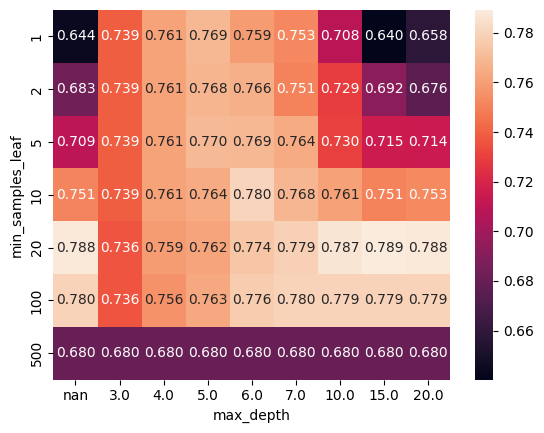

In [33]:
sns.heatmap(df_scores_pivot, annot=True, fmt=".3f")

In [34]:
df = DecisionTreeClassifier(max_depth=7, min_samples_leaf=20)
df.fit(X_train, y_train)

y_pred =df.predict_proba(X_val)[:,1]
roc_auc_score(y_val, y_pred)

0.7800458937783052

### Ensemble Learning and Random Forest

In [35]:
from sklearn.ensemble import RandomForestClassifier

In [36]:
rf = RandomForestClassifier(n_estimators=10)
rf.fit(X_train, y_train)

,n_estimators,10
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [37]:
y_pred = rf.predict_proba(X_val)[:,1]
roc_auc_score(y_val, y_pred)

0.7785806834419122

In [38]:
rf.predict_proba(X_val[[0]])

array([[0.9, 0.1]])

In [39]:
scores = []
for n in range(10,201,10):
    rf = RandomForestClassifier(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)

    y_pred= rf.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val, y_pred)
    scores.append((n,auc))

Text(0, 0.5, 'AUC')

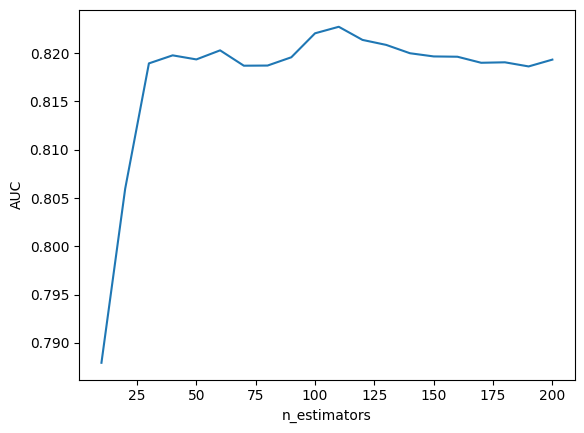

In [40]:
scores_df = pd.DataFrame(scores, columns=['n_estimators', 'auc'])
plt.plot(scores_df.n_estimators, scores_df.auc)
plt.xlabel('n_estimators')
plt.ylabel('AUC')

In [41]:
scores = []
for d in [5,10,15]:
    for n in range(10,201,10):
        rf = RandomForestClassifier(n_estimators=n,max_depth=d, random_state=1)
        rf.fit(X_train, y_train)

        y_pred= rf.predict_proba(X_val)[:,1]
        auc = roc_auc_score(y_val, y_pred)
        scores.append((d,n,auc))

In [42]:
scores_df = pd.DataFrame(scores, columns=['max_depth','n_estimators', 'auc'])
scores_df.head()

,max_depth,n_estimators,auc
0,5,10,0.789806
1,5,20,0.798682
2,5,30,0.803190
3,5,40,0.803507
4,5,50,0.804119


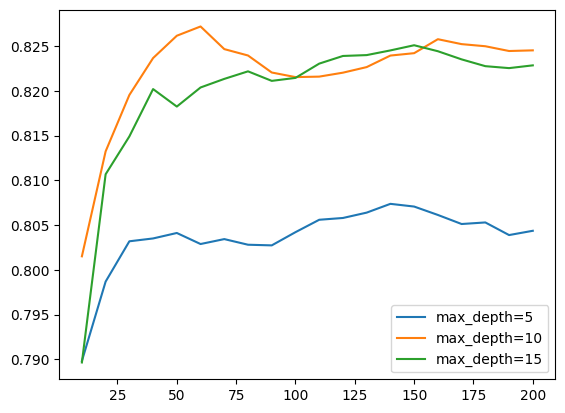

In [43]:
for d in [5,10,15]:
    df_subset = scores_df[scores_df['max_depth']==d]    
    plt.plot(df_subset.n_estimators, df_subset.auc,label=f'max_depth={d}')
plt.legend()

In [44]:
max_depth = 10

In [45]:
scores = []
for s in [1,3,5,10,50]:
    for n in range(10,201,10):
        rf = RandomForestClassifier(n_estimators=n,max_depth=max_depth,min_samples_leaf=s, random_state=1)
        rf.fit(X_train, y_train)

        y_pred= rf.predict_proba(X_val)[:,1]
        auc = roc_auc_score(y_val, y_pred)
        scores.append((s,n,auc))

In [46]:
scores_df = pd.DataFrame(scores, columns=['min_samples_leaf','n_estimators', 'auc'])
scores_df.head()

,min_samples_leaf,n_estimators,auc
0,1,10,0.801509
1,1,20,0.813243
2,1,30,0.819546
3,1,40,0.823675
4,1,50,0.826173


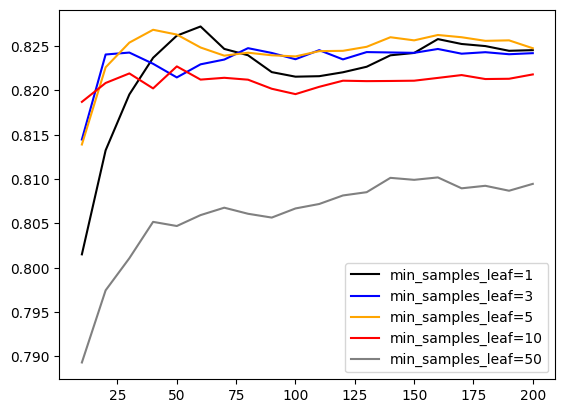

In [47]:
colors = ['black', 'blue', 'orange', 'red', 'grey']
min_samples_leaf=[1,3,5,10,50]
for s,col in zip(min_samples_leaf, colors):
    df_subset = scores_df[scores_df['min_samples_leaf']==s]    
    plt.plot(df_subset.n_estimators, df_subset.auc,label=f'min_samples_leaf={s}',color=col)
plt.legend()

In [48]:
min_samples_leaf = 3

In [49]:
rf = RandomForestClassifier(n_estimators=100,max_depth=max_depth,min_samples_leaf=min_samples_leaf, random_state=1,n_jobs=-1)
rf.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,3
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


### Gradient Boosting and XGBoost

In [52]:
# !pip install xgboost

In [53]:
import xgboost as xgb

In [61]:
features = dv.get_feature_names_out()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features.tolist())
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features.tolist())

In [69]:
watchlist = [(dtrain, 'train'), (dval, 'eval')]

In [76]:
%%capture output
xgb_params = {
    'eta':0.3,
    'max_depth':6,
    'min_child_weight':1,
    'objective':'binary:logistic',
    'eval_metric':'auc',
    'nthread':8,
    'seed':1,
    'verbosty':1
}
model = xgb.train(xgb_params, dtrain,verbose_eval=5,evals=watchlist, num_boost_round=200)

In [96]:
def parse_xgb_output(output):
    results = []
    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    columns=['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [97]:
df_score = parse_xgb_output(output)

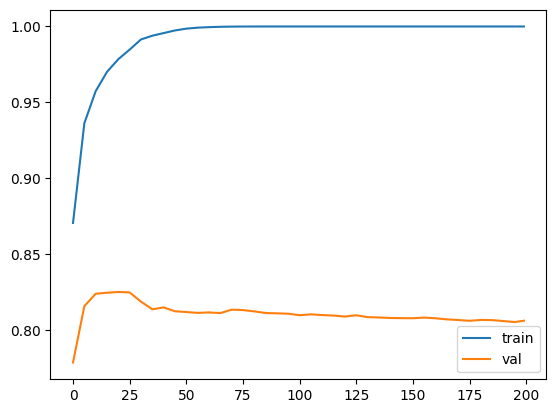

In [98]:
plt.plot(df_score.num_iter, df_score.train_auc, label='train')
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()

In [78]:
y_pred =model.predict(dval)

In [100]:
roc_auc_score(y_val, y_pred)

0.806328861010874